# Self learning 
## Clasificación semisupervisada

La clasificación consiste en la asignación de una categoría a un objeto/individuo (o a varios) .

En cualquier problema de clasificación hay que identificar 
* que cosas/objetos/individuos queremos clasificar, 
* que datos (o variables medidas) tenemos de estos y 
* cuáles (o cuántas) serían las (posibles) categorias o clases.

En **clasificación supervisada** se requiere tener a disposición un conjunto de muestras u objetos ya clasificados (tiene que ser numeroso y representativo). Con este conjunto se aprende a clasificar nuevas muestras y es llamado conjunto de entrenamiento. Cuando además ya tenemos de antemano muestras no clasificadas y las consideramos en la clasificación lo llamamos **clasificación semisupervisada**

En esta notebook veremos **Clasificación semisupervisada dentro de una imagen**

## Clasificación de imágenes 

Primero hay que identificar que tipo de clasificación se quiere realizar:

* **Dentro de una imagen (clasificación de pixeles, segmentación, detección de zonas)** o 
* **Asignar una imagen completa a una categoría (etiquetado, taggeo)**

Abordaremos 

### Clasificación dentro de una imagen $\leftrightarrow $ Segmentación

Dividir a la imagen en regiones. Los objetos/muestras a clasificar son los pixeles. ¿Qué datos/variables/características/features tenemos (o podemos obtener) de cada pixel.

Cada pixel tiene un vector de datos o características, puede tener una, tres o más (características/datos).

**Ejemplo:** imágenes a color RGB

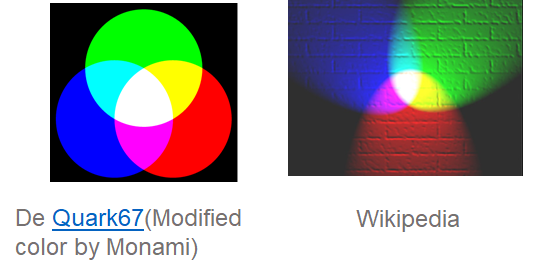

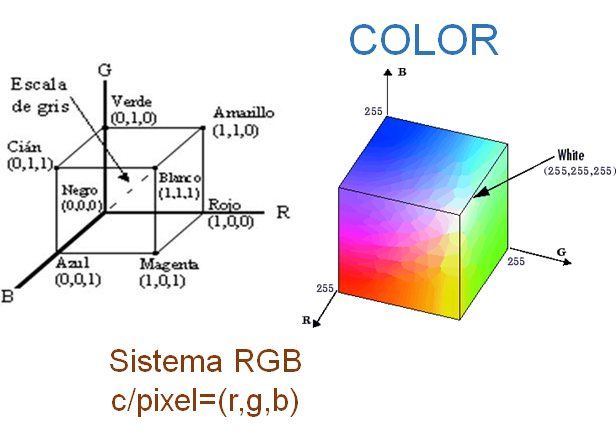

En Python primero hay que instalar (por única vez) alguna librería para leer imágenes: opencv, PIL o SimpleITK

In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier

(359, 479, 3)
dimensiones de la imagen:  (359, 479, 3) es decir:  359 x 479  pixeles RGB
tipo de datos:  uint8


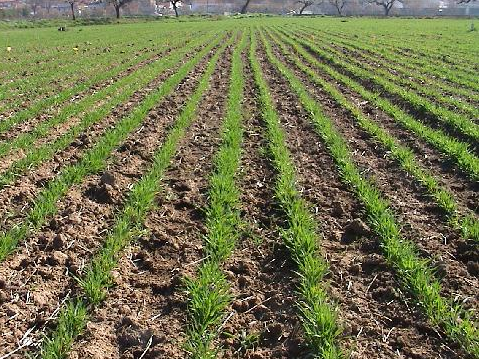

In [2]:
campo_cv=cv2.imread('/content/sample_data/Campo.png')
print(campo_cv.shape)
campo=campo_cv.copy()
campo[:,:,[2,1,0]]=campo_cv #cv2 lee en orden BGR'
print('dimensiones de la imagen: ', campo.shape, 'es decir: ', campo.shape[0],'x',campo.shape[1],' pixeles RGB')
print('tipo de datos: ', campo.dtype)
cv2_imshow(campo_cv)

componente roja(R) del pixel (0,0): 186
componente verde(G) del pixel (0,0): 155


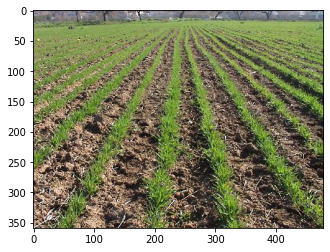

In [3]:
plt.imshow(campo)
print('componente roja(R) del pixel (0,0):', campo[0,0,0])
print('componente verde(G) del pixel (0,0):', campo[0,0,1])
plt.show()

# Clasificación supervisada-semisupervisada

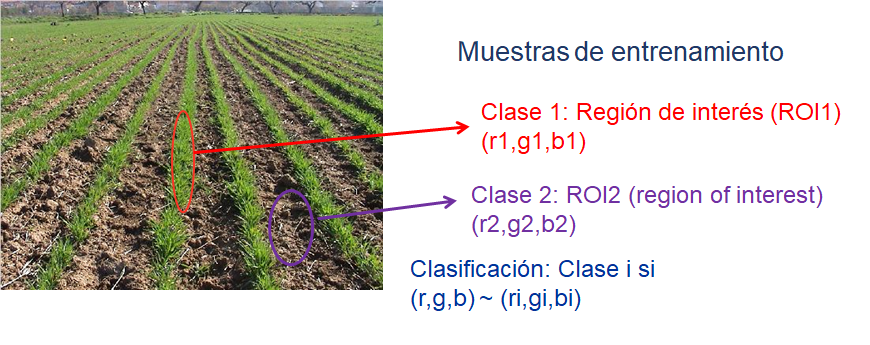

### k-nearest neibours -- k-vecinos más cercanos

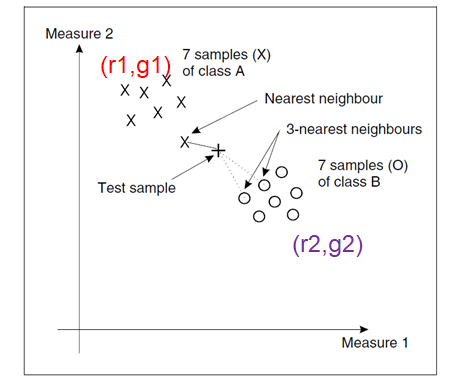

**Pasemos los pixeles a Dataframe**
un pixel por fila, desarmamos la espacialidad

In [4]:
dims=campo.shape
cant_filas=dims[0]
cant_columnas=dims[1]
cant_pixeles=cant_filas*cant_columnas
data0=np.zeros([cant_pixeles,4],dtype='int')
for f in range(cant_filas):
    for c in range(cant_columnas):
        nro=f*cant_columnas+c
        data0[nro,0]=nro
        data0[nro,1:4]=campo[f,c,:]
        
df = pd.DataFrame(data0, columns=["pixel_id","rojo","verde","azul"])

print('Tamaño de Base de pixeles:', df.shape)
df.head()        

Tamaño de Base de pixeles: (171961, 4)


,pixel_id,rojo,verde,azul
0,0,186,155,161
1,1,202,171,176
2,2,190,159,165
3,3,203,172,177
4,4,189,160,164


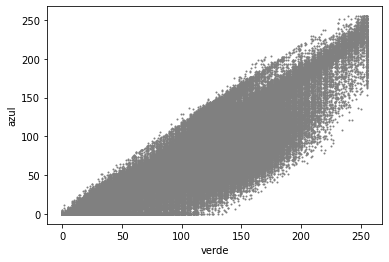

In [5]:
#import matplotlib.patches as mpatches

variables=["rojo","verde","azul"]

variable1=variables[1]
variable2=variables[2]

f1 = df[variable1].values
f2 = df[variable2].values

plt.scatter(f1, f2,c='gray', s=1)
plt.xlabel(variable1)
plt.ylabel(variable2)
plt.show()

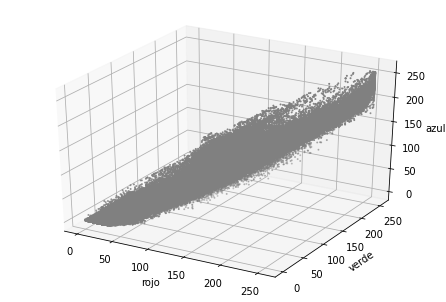

Un caramelo para el que encuentre clusters ahí!!


In [6]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df[variables[0]].values, df[variables[1]].values, df[variables[2]].values,c='gray', s=1)
ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])
plt.show()

print('Un caramelo para el que encuentre clusters ahí!!')

**Clustering** k-Medias (No supervisado)

In [7]:
from sklearn.cluster import KMeans
# Número de clusters buscado
n_clust = 3
df_km = pd.DataFrame(data0[:,1:4], columns=["rojo","verde","azul"])

km = KMeans(n_clusters=n_clust)
km.fit(df_km) #utiliza 3 dimensiones 

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  308726198.7228128


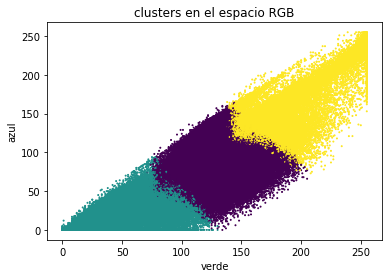

In [8]:
variables=["rojo","verde","azul"]

variable1=variables[1]
variable2=variables[2]

f1 = df[variable1].values
f2 = df[variable2].values

plt.scatter(f1, f2,c=clusters, s=1)
plt.xlabel(variable1)
plt.ylabel(variable2)
plt.title('clusters en el espacio RGB')
plt.show()

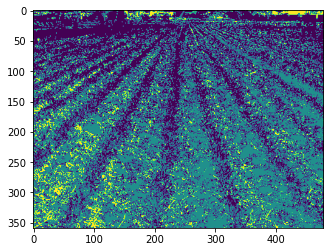

In [9]:
img_clusters=km.labels_.reshape(cant_filas,cant_columnas)
plt.imshow(img_clusters)
#plt.colorbar()
plt.show()

### Semi supervisado: Etiquetado de algunos pixeles: 
**Selección de cada ROI (Region of interest/Regiones de interés)**

IMPORTANTE: Los tres bloques siguientes sirven para elegir las regiones de entrenamiento y pueden reemplazarse por el que les sigue

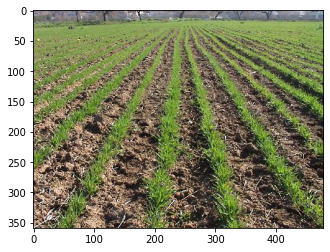

In [10]:
plt.imshow(campo)
plt.show()

In [11]:
roi1=(136, 241, 47, 106)#suelo
roi2=(192, 269, 33, 56) #pasto
roi3=(145, 1, 121, 14)#fondo
print('En cada ROI se guarda: (columna, fila, anchocol, anchofila)')

En cada ROI se guarda: (columna, fila, anchocol, anchofila)


In [12]:
rois=[roi1,roi2,roi3]

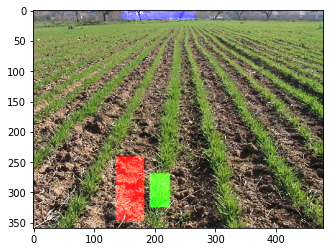

Rosa: suelo, Verde: pasto, Celeste: fondo


In [13]:
campo_rois=campo.copy()

for i in range(3):
  roi=rois[i]
  f1=roi[1]
  ff=roi[1]+roi[3]
  c1=roi[0]
  cf=roi[0]+roi[2]
  campo_rois[f1:ff,c1:cf,i]=255

plt.imshow(campo_rois)
plt.show()
print('Rosa: suelo, Verde: pasto, Celeste: fondo')

In [ ]:
cantidad=0
for i in range(3):
    cantidad=cantidad+(rois[i][2]*rois[i][3])
print (cantidad)
data=np.zeros([cantidad,5],dtype='int')
target=np.zeros(cantidad,dtype='int')
cuenta=0
for i in range(3):
    roi=rois[i]
    
    for fil in range (roi[1],roi[1]+roi[3]):
        for col in range (roi[0],roi[0]+roi[2]):
            nro=fil*cant_columnas+col
            data[cuenta,0]=nro
            data[cuenta,1:4]=campo[fil,col,:]
            data[cuenta,4]=i+1
            target[cuenta]=i+1
            cuenta=cuenta+1

df_etiquetado = pd.DataFrame(data, columns=["pixel_id","rojo","verde","azul","etiqueta"])
print(df_etiquetado.shape)
print('Base de pixeles etiquetados:')
df_etiquetado.head()



8524
(8524, 5)
Base de pixeles etiquetados:


,pixel_id,rojo,verde,azul,etiqueta
0,115575,101,104,77,1
1,115576,111,110,90,1
2,115577,104,97,89,1
3,115578,34,26,23,1
4,115579,29,22,16,1


**Graficamos los pixeles etiquetados (roi1,2 y 3: entrenamiento)**

cantidad de muestras etiquetadas: 8524
cantidad de clases etiquetadas: 3
cantidad de variables/dimension: 3
se grafican de a dos (dimensión 2)


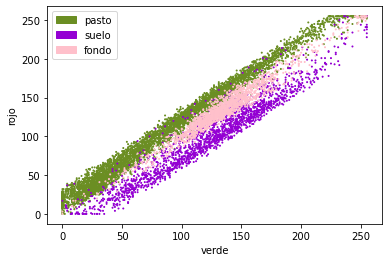

In [ ]:
colores=['olivedrab','darkviolet','pink']
variables=["rojo","verde","azul"]

variable1=variables[1]
variable2=variables[0]

f1 = df_etiquetado[variable1].values
f2 = df_etiquetado[variable2].values
f3 = target

# Vamos a pintar en colores las 3 clases: verde: 0, azul:1, rosa:2
asignar=[]
l=len(f3)
print('cantidad de muestras etiquetadas:',l)
print('cantidad de clases etiquetadas:',3)
print('cantidad de variables/dimension:',3)
print('se grafican de a dos (dimensión 2)')

for k in range(l): #for index, row in filtered_data.iterrows():
    if(f3[k]==1):
        asignar.append(colores[0])
    elif (f3[k]==2):
        asignar.append(colores[1])
    else:
        asignar.append(colores[2])
plt.scatter(f1, f2, c=asignar, s=1)
plt.xlabel(variable1)
plt.ylabel(variable2)
patch1 = mpatches.Patch(color=colores[0], label='pasto')
patch2 = mpatches.Patch(color=colores[1], label='suelo')
patch3 = mpatches.Patch(color=colores[2], label='fondo')
plt.legend(handles=[patch1,patch2,patch3])
plt.show()

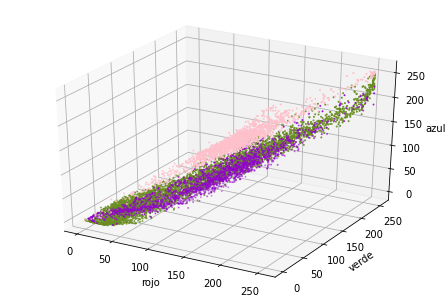

In [ ]:
fig =plt.figure()
ax = Axes3D(fig)

ax.scatter(df_etiquetado[variables[0]].values, df_etiquetado[variables[1]].values, df_etiquetado[variables[2]].values,c=asignar, s=1)
ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])
plt.show()

   pixel_id  rojo  verde  azul  etiqueta
0         0   186    155   161         0
1         1   202    171   176         0
2         2   190    159   165         0
3         3   203    172   177         0
4         4   189    160   164         0
163437
171961
proporción de datos etiqueados: 0.049569379103401354


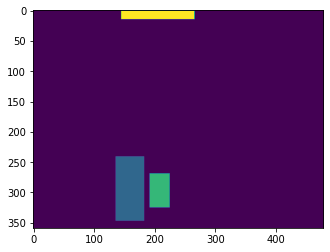

In [ ]:
#Base completa con etiquetas y no etiquetados en 0
a=campo.shape
df_completo=df.copy()
df_completo.astype(int)## cambiar el tipo de dato 
df_completo['etiqueta']=0*df_completo['rojo']
#se asignan en el completo las etiquetas de ROIS
for i in range(l):
    lugar=df_etiquetado['pixel_id'][i].astype(int)
    df_completo['etiqueta'][lugar]=df_etiquetado['etiqueta'][i]
print(df_completo.head())
print(sum(df_completo.etiqueta==0))
print(cant_pixeles)
print('proporción de datos etiqueados:',sum(df_completo.etiqueta!=0)/cant_pixeles)
clasif_rois=df_completo.etiqueta.values.reshape(a[0],a[1])
plt.imshow(clasif_rois)
plt.show()

**Entrenamos un modelo k-Nearest Neighbor con los pixeles que etiquetamos  (roi1, 2 y 3)** 

con Scikit Learn Elegimos el valor de k=5 (5 vecinos, es un hiper-parámetro)

In [ ]:
n_neighbors = 5
data_rgb=data[:,1:4]

knn = KNeighborsClassifier(n_neighbors)
knn.fit(data_rgb, target)
print('Presición (Accuracy) del clasificador K-NN en el conjunto de entrenamiento: {:.2f}'
     .format(knn.score(data_rgb, target)))

Presición (Accuracy) del clasificador K-NN en el conjunto de entrenamiento: 0.97


### Clasificación

Clasifiquemos la imagen completa: Se clasifican todos usando el modelo entrenado

(359, 479, 3)
[2]


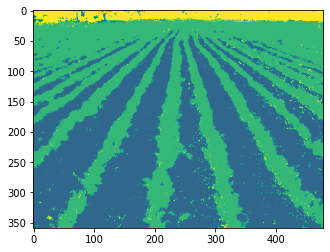

In [ ]:
a=campo.shape
print(a)
clasif=np.zeros(a[0:2],dtype='int')
print(knn.predict([[40, 80, 40]]))
for i in range(a[0]): #filas
    for j in range(a[1]): #columnas
        clasif[i,j]=knn.predict([campo[i,j,:]])        
clasif[0,0]=0 #para unificar paletas (con 4 colores)         
plt.imshow(clasif)
plt.show()        

#### Mejora de la clasificación: co-learning/training

Usando conocimiento de dominio: en imágenes, por ejemplo, la información espacial

* Filtro o algoritmo de modas (puede ser iterado)
* Moda: es el valor más repetido

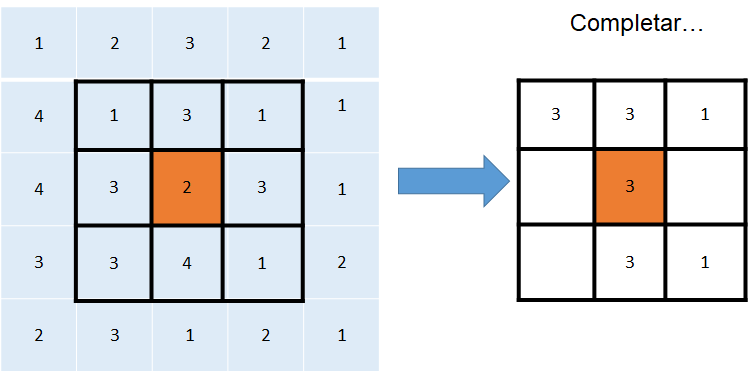

In [ ]:
from statistics import mode
clasif2=clasif.copy()
for i in range(2,a[0]-2): #filas
    for j in range(2,a[1]-2): #columnas
        try:
            clasif2[i,j]=mode(clasif[i-2:i+3,j-2:j+3].ravel())
        except:
            clasif2[i,j]=clasif[i,j]
clasif2[0,0]=0 #para unificar paletas (con 4 colores)        

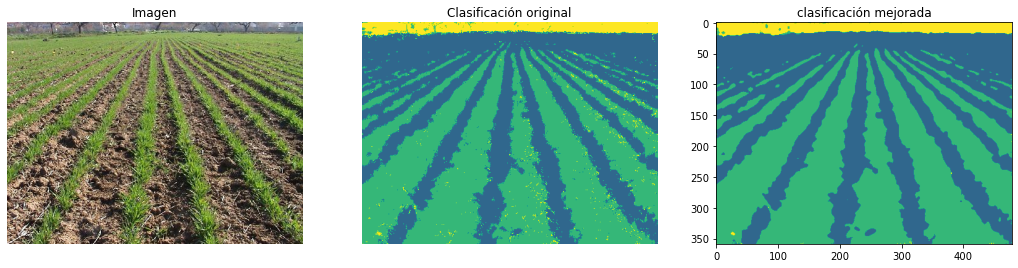

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(18)
axs[0].imshow(campo)
axs[0].set_title("Imagen")
axs[0].axis('off')
axs[1].imshow(clasif)
axs[1].set_title("Clasificación original")
axs[1].axis('off')
axs[2].imshow(clasif2)
axs[2].set_title('clasificación mejorada')
#axs[2].axis('off')
plt.show()

### Asignación progresiva

In [ ]:
n_neighbors = 6
#data_rgb=data[:,1:4]
knn6 = KNeighborsClassifier(n_neighbors)
knn6.fit(data_rgb, target)
print('Presición (Accuracy) del clasificador K-NN con k=6 en el conjunto de entrenamiento: {:.2f}'
     .format(knn6.score(data_rgb, target)))


Presición (Accuracy) del clasificador K-NN con k=6 en el conjunto de entrenamiento: 0.97


**Utilizamos algún criterio para incrementar la muestra de entrenamiento de manera progresiva**

Elegimos comparar 5 vecinos con 6 vecinos, si coincide lo suma a la muestra de entrenamiento. 

2132
proporción de datos sin etiquetar: [0.012398160047917842]


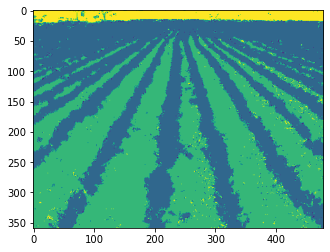

In [ ]:
##loop 1
prop=[]
r1s= knn.predict(data0[:,1:4])
r2s= knn6.predict(data0[:,1:4])
for i in range(cant_pixeles):
    if df_completo.etiqueta[i]==0:
        r1= r1s[i]
        r2= r2s[i]
        if r1==r2:
            df_completo.etiqueta[i]=r1

print(sum(df_completo.etiqueta==0))        

clasif_iter=df_completo.etiqueta.values.reshape(a[0],a[1])

prop.append(sum(df_completo.etiqueta==0)/cant_pixeles)
print('proporción de datos sin etiquetar:',prop)        
plt.imshow(clasif_iter)
        

**Se entrena de nuevo los clasificadores con las muetras de entrenamiento actualizadas** y se usa el mismo criterio para etiquetar nuevos datos

comparar knn 5 vecinos con knn 6 vecinos, si coincide lo agrega a la muestra de entrenamiento y así siguiendo... 

de datos sin etiquetar: 181
proporción de datos sin etiquetar: [0.012398160047917842, 0.0010525642442181658]


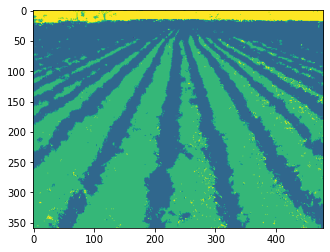

In [ ]:
##loop 2
data_rgb=df_completo[df_completo.etiqueta!=0].values[:,1:4]
target=df_completo.etiqueta[df_completo.etiqueta!=0]
knn.fit(data_rgb, target)
knn6.fit(data_rgb, target)

r1s= knn.predict(data0[:,1:4])
r2s= knn6.predict(data0[:,1:4])
for i in range(cant_pixeles):
    if df_completo.etiqueta[i]==0:
        r1= r1s[i]
        r2= r2s[i]
        if r1==r2:
            df_completo.etiqueta[i]=r1

print('de datos sin etiquetar:',sum(df_completo.etiqueta==0))        

clasif_iter=df_completo.etiqueta.values.reshape(a[0],a[1])

prop.append(sum(df_completo.etiqueta==0)/cant_pixeles)
print('proporción de datos sin etiquetar:',prop)        
plt.imshow(clasif_iter)
        

de datos sin etiquetar: 78
proporción de datos sin etiquetar: [0.012398160047917842, 0.0010525642442181658, 0.0004535912212652869]


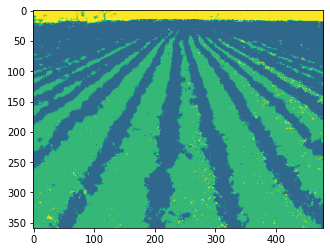

In [ ]:
##loop 3
data_rgb=df_completo[df_completo.etiqueta!=0].values[:,1:4]
target=df_completo.etiqueta[df_completo.etiqueta!=0]
knn.fit(data_rgb, target)
knn6.fit(data_rgb, target)

r1s= knn.predict(data0[:,1:4])
r2s= knn6.predict(data0[:,1:4])
for i in range(cant_pixeles):
    if df_completo.etiqueta[i]==0:
        r1= r1s[i]
        r2= r2s[i]
        if r1==r2:
            df_completo.etiqueta[i]=r1

print('de datos sin etiquetar:',sum(df_completo.etiqueta==0))        

clasif_iter=df_completo.etiqueta.values.reshape(a[0],a[1])

prop.append(sum(df_completo.etiqueta==0)/cant_pixeles)
print('proporción de datos sin etiquetar:',prop)        
plt.imshow(clasif_iter)

de datos sin etiquetar: 64
proporción de datos sin etiquetar: [0.012398160047917842, 0.0010525642442181658, 0.0004535912212652869, 0.0003721774123202354]


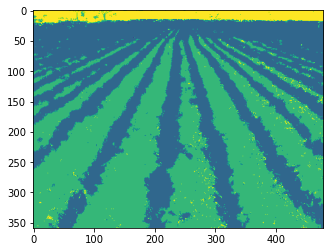

In [ ]:
##loop 4
data_rgb=df_completo[df_completo.etiqueta!=0].values[:,1:4]
target=df_completo.etiqueta[df_completo.etiqueta!=0]
knn.fit(data_rgb, target)
knn6.fit(data_rgb, target)

r1s= knn.predict(data0[:,1:4])
r2s= knn6.predict(data0[:,1:4])
for i in range(cant_pixeles):
    if df_completo.etiqueta[i]==0:
        r1= r1s[i]
        r2= r2s[i]
        if r1==r2:
            df_completo.etiqueta[i]=r1

print('de datos sin etiquetar:',sum(df_completo.etiqueta==0))        

clasif_iter=df_completo.etiqueta.values.reshape(a[0],a[1])

prop.append(sum(df_completo.etiqueta==0)/cant_pixeles)
print('proporción de datos sin etiquetar:',prop)        
plt.imshow(clasif_iter)

de datos sin etiquetar: 58
proporción de datos sin etiquetar: [0.012398160047917842, 0.0010525642442181658, 0.0004535912212652869, 0.0003721774123202354, 0.00033728577991521335]


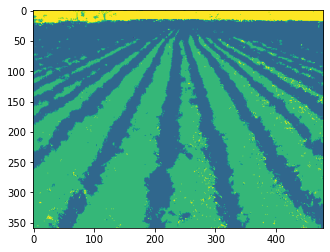

In [ ]:
##loop 5
data_rgb=df_completo[df_completo.etiqueta!=0].values[:,1:4]
target=df_completo.etiqueta[df_completo.etiqueta!=0]
knn.fit(data_rgb, target)
knn6.fit(data_rgb, target)

r1s= knn.predict(data0[:,1:4])
r2s= knn6.predict(data0[:,1:4])
for i in range(cant_pixeles):
    if df_completo.etiqueta[i]==0:
        r1= r1s[i]
        r2= r2s[i]
        if r1==r2:
            df_completo.etiqueta[i]=r1

print('de datos sin etiquetar:',sum(df_completo.etiqueta==0))        

clasif_iter=df_completo.etiqueta.values.reshape(a[0],a[1])

prop.append(sum(df_completo.etiqueta==0)/cant_pixeles)
print('proporción de datos sin etiquetar:',prop)        
plt.imshow(clasif_iter)

**Si no se tuvieron buenos resultados puede ser por muchos motivos:**
* el algoritmo puede fallar y no converger a los aglomerados 
* las características consideradas no son suficientes o no son las adecuadas, por ejemplo.